<a href="https://colab.research.google.com/github/js-iMore/Analitica_tareas/blob/master/Housing_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Probando Clustering en la base de datos de Housing

In [0]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

#Acceso a los archivos desde Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#
file_id1 = '1pXnhCBJ-zS5n-rwA-Bn3o5_leYx2npEz' #Base de datos
csv_path = drive.CreateFile({'id': file_id1})
csv_path.GetContentFile('housing.csv') 

file_id2 = '1Z5oNBn5_7MpqohWsXQBFEDBD0A509xKi'
funcionesH = drive.CreateFile({'id': file_id2})
funcionesH.GetContentFile('fun_clus_housing.py') #Funciones

from fun_clus_housing import graph_PCA


%matplotlib inline

img_path = ''
Xdata = pd.read_csv('housing.csv')

In [0]:
Xdata.info()
X = Xdata

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#Preprocesamiento de los datos

In [0]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

ordinal_encoder = OrdinalEncoder()
X["ocean_proximity"] = ordinal_encoder.fit_transform(X[["ocean_proximity"]])
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
columns = X.columns
X = imputer.transform(X)
X=pd.DataFrame(X, columns=columns) 

##KMeans

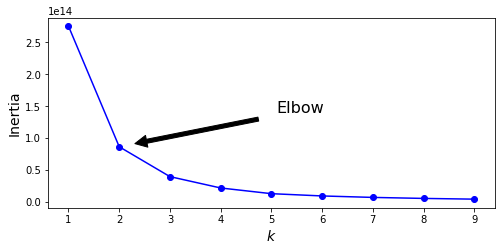

In [0]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

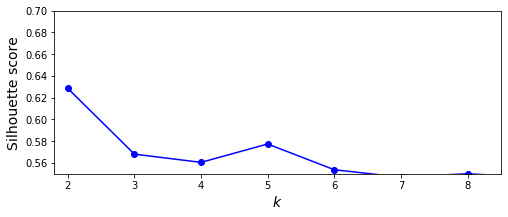

In [0]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

In [0]:
#El número de clusters sería 2 según los resultados, entonces:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
Y = kmeans.fit_predict(X)

##Ahora graficar los clusters utilizando PCA

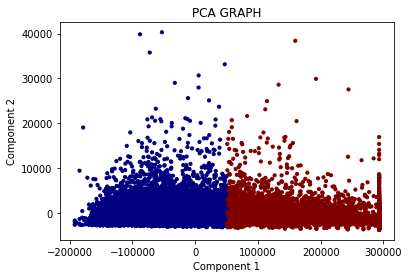

In [0]:
graph_PCA(X,Y)

##Prueba con mini-batch K-Means

In [0]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

filename = "./data.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X.shape)
X_mm[:] = X

minibatch_kmeans = MiniBatchKMeans(n_clusters=3, batch_size=10, random_state=42)
Z = minibatch_kmeans.fit_predict(X_mm)

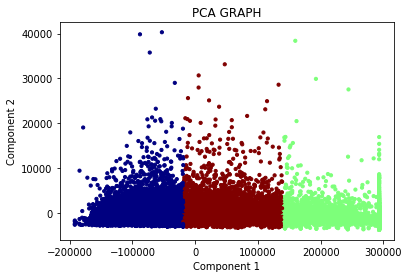

In [0]:
graph_PCA(X,Z)

##DBSCAN

In [0]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.01,min_samples=5)
print(dbscan.fit(X))

dbscan.labels_

DBSCAN(algorithm='auto', eps=0.01, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)


array([-1, -1, -1, ..., -1, -1, -1])

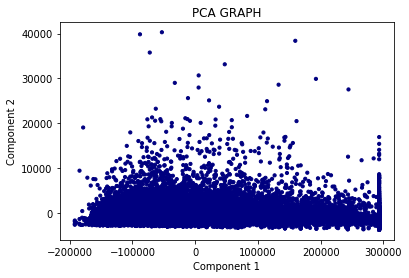

In [0]:
graph_PCA(X,dbscan.labels_)

##Finalmente SpectralClustering

In [0]:
X.shape

(20640, 10)

In [0]:
X_ = X.iloc[:100]
X_.shape

(100, 10)

In [0]:
from sklearn.cluster import SpectralClustering
spec = SpectralClustering(n_clusters=2, gamma=10, random_state=42)
spec.fit(X_)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=10,
                   kernel_params=None, n_clusters=2, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=42)

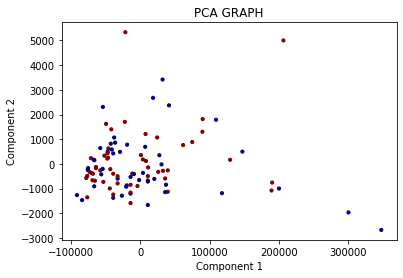

In [0]:
graph_PCA(X_,spec.labels_)